# Imports

In [356]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from itertools import product

# Configs

In [357]:
INPUT_PATH = 'data/pair_labels.parquet'
OUTPUT_PATH = 'results/pairs_ridge_predictions.parquet'

START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

FEATURE_LIST = [
                #'Ridge_predict',

                'Previous_week_max_demand',
                'Previous_2week_max_demand',

                'Previous_2week_demand',
                'Previous_week_demand', 


                'Previous_day_demand',
                'Previous_2day_demand',
                'Previous_3day_demand',
                'Previous_4day_demand',
                'Previous_5day_demand',
                'Previous_6day_demand',
                'Previous_8day_demand',
                'Previous_9day_demand',
                'Previous_10day_demand',
                'Previous_11day_demand',
                'Previous_12day_demand',
                'Previous_13day_demand',

                'Day_of_month', 
                'Day_of_week',
                ]

VALIDATION_START_DATE = '2023-03-21'
TEST_START_DATE = '2023-04-01'

AUTO_TUNE = False

# Data preparation


## Labeling

In [358]:
labeled_df = pd.read_parquet(INPUT_PATH)

In [359]:
print(f'labeled dataframe shape : {labeled_df.shape}')
labeled_df.head()

labeled dataframe shape : (600, 4)


,PULocation,Date,DOLocation,Demand
0,236,2023-01-01,236,153.0
1,236,2023-01-02,236,273.0
2,236,2023-01-03,236,490.0
3,236,2023-01-04,236,537.0
4,236,2023-01-05,236,522.0


## Add Feature

In [360]:
def feature_engineering(dataset):
    dataset['Previous_day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(1)
    dataset['Previous_2day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(2)
    dataset['Previous_3day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(3)
    dataset['Previous_4day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(4)
    dataset['Previous_5day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(5)
    dataset['Previous_6day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(6)
    dataset['Previous_week_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(7)
    dataset['Previous_8day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(8)
    dataset['Previous_9day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(9)
    dataset['Previous_10day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(10)
    dataset['Previous_11day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(11)
    dataset['Previous_12day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(12)
    dataset['Previous_13day_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(13)
    dataset['Previous_2week_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].shift(14)

    dataset['Previous_week_max_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].rolling(window=7).max().reset_index(drop = True)
    dataset['Previous_2week_max_demand'] = dataset.groupby(['PULocation', 'DOLocation'])['Demand'].rolling(window=14).max().reset_index(drop = True)

    dataset['Day_of_week'] = dataset['Date'].dt.dayofweek   
    dataset['Day_of_month'] = dataset['Date'].dt.day
    
    return dataset


In [361]:
features_df = feature_engineering(labeled_df)
features_df.dropna(inplace = True)

In [362]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (530, 22)


,PULocation,Date,DOLocation,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,...,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month
14,236,2023-01-15,236,268.0,366.0,548.0,632.0,572.0,579.0,511.0,...,579.0,522.0,537.0,490.0,273.0,153.0,632.0,632.0,6,15
15,236,2023-01-16,236,343.0,268.0,366.0,548.0,632.0,572.0,579.0,...,442.0,579.0,522.0,537.0,490.0,273.0,632.0,632.0,0,16
16,236,2023-01-17,236,481.0,343.0,268.0,366.0,548.0,632.0,572.0,...,316.0,442.0,579.0,522.0,537.0,490.0,632.0,632.0,1,17
17,236,2023-01-18,236,562.0,481.0,343.0,268.0,366.0,548.0,632.0,...,511.0,316.0,442.0,579.0,522.0,537.0,632.0,632.0,2,18
18,236,2023-01-19,236,671.0,562.0,481.0,343.0,268.0,366.0,548.0,...,579.0,511.0,316.0,442.0,579.0,522.0,671.0,671.0,3,19


## Split Train and Test Data

In [363]:
def train_test_splitting(dataset, TEST_START_DATE):

    train_df = dataset[dataset['Date'] < TEST_START_DATE]
    test_df = dataset[dataset['Date'] >= TEST_START_DATE]

    return train_df, test_df

In [364]:
train_df, test_df = train_test_splitting(features_df, TEST_START_DATE)

In [365]:
grid_search_train_df, valid_df = train_test_splitting(train_df, VALIDATION_START_DATE) 

In [366]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (380, 22)


,PULocation,Date,DOLocation,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,...,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month
14,236,2023-01-15,236,268.0,366.0,548.0,632.0,572.0,579.0,511.0,...,579.0,522.0,537.0,490.0,273.0,153.0,632.0,632.0,6,15
15,236,2023-01-16,236,343.0,268.0,366.0,548.0,632.0,572.0,579.0,...,442.0,579.0,522.0,537.0,490.0,273.0,632.0,632.0,0,16
16,236,2023-01-17,236,481.0,343.0,268.0,366.0,548.0,632.0,572.0,...,316.0,442.0,579.0,522.0,537.0,490.0,632.0,632.0,1,17
17,236,2023-01-18,236,562.0,481.0,343.0,268.0,366.0,548.0,632.0,...,511.0,316.0,442.0,579.0,522.0,537.0,632.0,632.0,2,18
18,236,2023-01-19,236,671.0,562.0,481.0,343.0,268.0,366.0,548.0,...,579.0,511.0,316.0,442.0,579.0,522.0,671.0,671.0,3,19


In [367]:
print(f'validation dataframe shape : {valid_df.shape}')
valid_df.head()

validation dataframe shape : (55, 22)


,PULocation,Date,DOLocation,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,...,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month
79,236,2023-03-21,236,401.0,389.0,286.0,372.0,540.0,605.0,662.0,...,311.0,398.0,655.0,625.0,638.0,585.0,662.0,662.0,1,21
80,236,2023-03-22,236,403.0,401.0,389.0,286.0,372.0,540.0,605.0,...,646.0,311.0,398.0,655.0,625.0,638.0,605.0,662.0,2,22
81,236,2023-03-23,236,449.0,403.0,401.0,389.0,286.0,372.0,540.0,...,607.0,646.0,311.0,398.0,655.0,625.0,540.0,662.0,3,23
82,236,2023-03-24,236,429.0,449.0,403.0,401.0,389.0,286.0,372.0,...,662.0,607.0,646.0,311.0,398.0,655.0,449.0,662.0,4,24
83,236,2023-03-25,236,313.0,429.0,449.0,403.0,401.0,389.0,286.0,...,605.0,662.0,607.0,646.0,311.0,398.0,449.0,662.0,5,25


In [368]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (150, 22)


,PULocation,Date,DOLocation,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,...,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month
90,236,2023-04-01,236,317.0,416.0,533.0,474.0,405.0,485.0,224.0,...,449.0,403.0,401.0,389.0,286.0,372.0,533.0,533.0,5,1
91,236,2023-04-02,236,297.0,317.0,416.0,533.0,474.0,405.0,485.0,...,429.0,449.0,403.0,401.0,389.0,286.0,533.0,533.0,6,2
92,236,2023-04-03,236,570.0,297.0,317.0,416.0,533.0,474.0,405.0,...,313.0,429.0,449.0,403.0,401.0,389.0,570.0,570.0,0,3
93,236,2023-04-04,236,613.0,570.0,297.0,317.0,416.0,533.0,474.0,...,224.0,313.0,429.0,449.0,403.0,401.0,613.0,613.0,1,4
94,236,2023-04-05,236,673.0,613.0,570.0,297.0,317.0,416.0,533.0,...,485.0,224.0,313.0,429.0,449.0,403.0,673.0,673.0,2,5


# Model Training

## **Ridge Regression**

### Model Tuning

In [369]:
def grid_search(model_class, param_grid, train_df, val_df, feature_list):
    best_params = None
    best_val_loss = float('inf')

    for params in product(*param_grid.values()):
        current_params = dict(zip(param_grid.keys(), params))
        current_model = model_class(**current_params)
        current_model.fit(train_df[feature_list], train_df['Demand'])
        
        y_val_pred = current_model.predict(val_df[feature_list])
        val_loss = mean_squared_error(val_df['Demand'], y_val_pred)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = current_params
    
    return best_params, best_val_loss

In [370]:
model = Lasso
best_params, best_score = grid_search(
    model, 
    {'alpha':range(1, 100)},
    grid_search_train_df,
    valid_df, 
    FEATURE_LIST
    )

print(best_params, best_score)

{'alpha': 2} 6960.714914771321


### Prediction

In [371]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])


    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [372]:
model = Lasso(**best_params)
train_prediction_df , test_prediction_df  = model_predict(model, train_df, test_df, FEATURE_LIST)

### Visualization

In [373]:
def add_day_of_year(data):
    data['day_year'] = 0
    start_date = data['Date'].min()

    for index, row in data.iterrows():

        curr_date = row['Date']
        day_number = (curr_date - start_date).days

        data.at[index, 'day_year'] = day_number
    return data

In [374]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):


    train_data = add_day_of_year(train_data)
    test_data = add_day_of_year(test_data)

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

C:\Users\bardia\AppData\Local\Temp\ipykernel_21592\2975102461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_year'] = 0
C:\Users\bardia\AppData\Local\Temp\ipykernel_21592\2975102461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_year'] = 0
C:\Users\bardia\AppData\Local\Temp\ipykernel_21592\2246591508.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

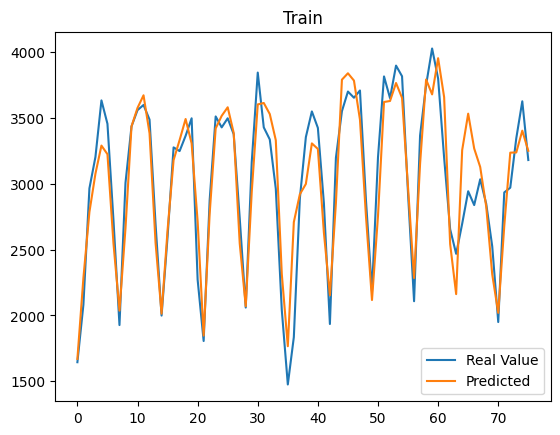

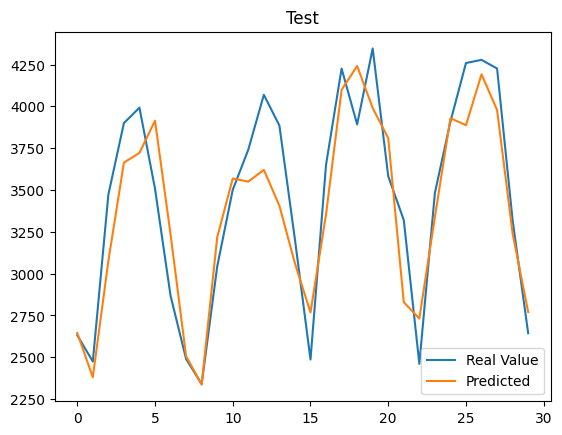

In [375]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [376]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [377]:
def evaluation(model_name, train_data, test_data, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_data['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_data['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_data['Demand'], train_prediction_df)

    print(f'{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_data['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_data['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_data['Demand'], test_prediction_df)


In [378]:
evaluation('Ridge Regression', train_df, test_df, train_prediction_df, test_prediction_df)

Ridge Regression train scores:
MAE : 57.483996820552136
MSE : 5502.360115605051
MAPE : 0.10430702319865996
Ridge Regression test scores:
MAE : 60.44565074271304
MSE : 6096.37495215998
MAPE : 0.08996650545224595


# File Saving

In [379]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [380]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [381]:
labeled_prediction_df = prediction_labeling(test_prediction_df, test_df)

KeyError: "['Location'] not in index"

In [382]:
print(f'labeled prediction dataframe shape : {labeled_prediction_df.shape}')
labeled_prediction_df.head()

NameError: name 'labeled_prediction_df' is not defined

In [383]:
save_predictions(labeled_prediction_df, OUTPUT_PATH)

NameError: name 'labeled_prediction_df' is not defined